<a href="https://colab.research.google.com/github/Nivehm/Workshop-Astra-Finansial-Python/blob/main/Workshop_(python)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analisa Data Transaksi**

Pada _workshop_ kali ini, kami akan memberikan contoh data transaksi yang didapatkan dari sistem CRM suatu minimarket di kota tertentu sejak bulan Januari 2020 hingga April 2020. Minimarket tersebut sudah terbiasa melakukan evaluasi performa setiap _quarter_.

Kita akan membuat dua analisa sederhana dari data ini, yakni:

- _Clustering_ pelanggan yang menjadi _member_.
- Membuat promo produk _bundling_.

Untuk melakukan analisa, akan ada empat tahap pengerjaan, yakni:

1. _Pre processing_ dengan menggabungkan empat data transaksi bulanan menjadi satu _dataframe_.
1. _Exploratory data analysis_ dengan membuat tabulasi dan visualisasi sederhana dari data tersebut.
1. _Clustering_ konsumen berdasarkan _framework_ __RFM__ (_retention_, _frequency_, dan _monetary_) dari masing-masing konsumen. Kelak akan didiskusikan strategi / _campaign marketing_ apa saja yang bisa kita berikan kepada masing-masing _cluster_ (kelompok) konsumen.
1. _Cross basket analysis_ untuk menganalisa dan memberikan saran produk apa saja yang bisa dijual berbarengan (_cross selling_ / _upselling_). Kita akan diskusikan juga nanti saat _workshop_.

## **Tahap I** _Pre Processing_

Pada tahap ini, kita akan _import_ semua data transaksi bulanan (format `.csv`) ke dalam _computing environment_).

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import re
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

In [5]:
df_1 = pd.read_csv('jan 2020.csv')
df_2 = pd.read_csv('feb 2020.csv')
df_3 = pd.read_csv('mar 2020.csv')
df_4 = pd.read_csv('apr 2020.csv')

df_all = pd.concat([df_1, df_2, df_3, df_4], axis=0) # Penggabungan data frame menggunakan pandas
df_all = df_all.drop('id', axis=1) # Menghapus kolom id
df_all['tanggal'] = pd.to_datetime(df_all['tanggal']) # Mengubah kolom tanggal menjadi data tipe date
df_all['bulan'] = df_all['tanggal'].dt.strftime('%B') # Menambahkan kolom bulan dengan tanggal sebagai acuan bulan
df_all = df_all.sort_values(by='tanggal').reset_index(drop=True) # Mengurutkan data berdasarkan tanggal
df_all = df_all[['id_transaksi','tanggal','bulan','hari','jam','ampm','id_pelanggan','sku','qty','unit','harga','diskon','total_harga']] #Mengatur ulang kolom dalam data frame

In [6]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34436 entries, 0 to 34435
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id_transaksi  34436 non-null  object        
 1   tanggal       34436 non-null  datetime64[ns]
 2   bulan         34436 non-null  object        
 3   hari          34436 non-null  object        
 4   jam           34436 non-null  int64         
 5   ampm          34436 non-null  object        
 6   id_pelanggan  34436 non-null  object        
 7   sku           34436 non-null  object        
 8   qty           34436 non-null  int64         
 9   unit          34436 non-null  object        
 10  harga         34436 non-null  float64       
 11  diskon        34436 non-null  float64       
 12  total_harga   34436 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(7)
memory usage: 3.4+ MB


Berikut adalah penjelasan beberapa variabel dari data yang sudah digabung:

- `id_transaksi`: __id__ dari satu transaksi.
- `tanggal`: tanggal transaksi.
- `id_pelanggan`: merupakan __id__ pelanggan. Pelanggan yang menjadi _member_ akan ditulis nomor _membership_-nya. Sedangkan pelanggan yang _non member_ ditulis sebagai __UMUM__.
- `sku`: merupakan nama produk yang dibeli.
- `diskon`: merupakan diskon produk dalam __persentase__.
- `total_harga`: merupakan harga total per `sku` yang merupakan perkalian dari `qty` dengan `harga` setelah dikurang `diskon`.

## **Tahap II** _Exploratory Data Analysis_

Sekarang kita akan buat EDA sederhana dari data gabungan yang ada.

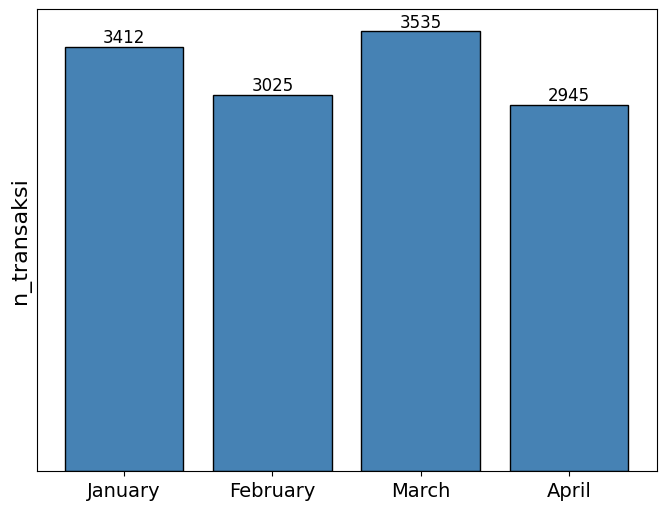

In [7]:
month_order = ["January", "February", "March", "April"] # Urutan bulan untuk sorting data frame


n_trans = df_all.groupby('bulan')['id_transaksi'].nunique().reset_index()
n_trans['bulan'] = pd.Categorical(n_trans['bulan'], categories=month_order, ordered=True)
n_trans = n_trans.sort_values('bulan')

plt.figure(figsize=(8,6))
bars = plt.bar(n_trans['bulan'], n_trans['id_transaksi'], color='steelblue', edgecolor='black')
plt.ylabel("n_transaksi", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks([])
for bar, label in zip(bars, n_trans['id_transaksi']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{label}', ha='center', va='bottom', fontsize=12)
plt.show()

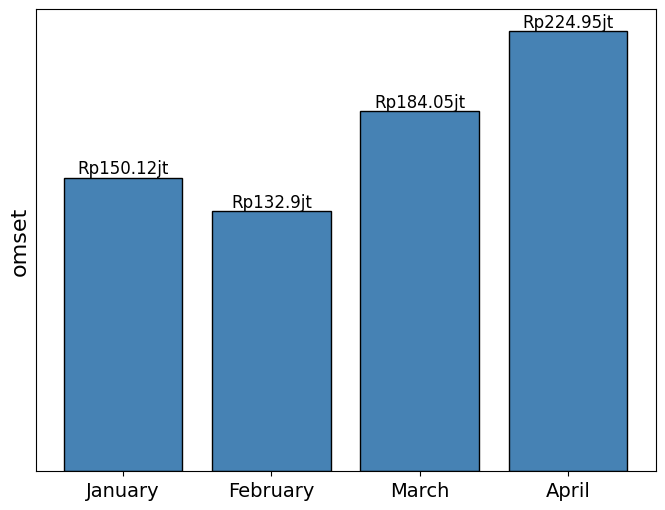

In [8]:
df_omset = df_all.groupby('bulan').agg(omset = ('total_harga', 'sum')).reset_index()
df_omset['bulan'] = pd.Categorical(df_omset['bulan'], categories=month_order, ordered=True)
df_omset = df_omset.sort_values('bulan')
df_omset['xlabel'] = (df_omset['omset']/1000000).round(2)
df_omset ['xlabel']= "Rp" + df_omset['xlabel'].astype(str) + "jt"

plt.figure(figsize=(8,6))
bar = plt.bar(df_omset['bulan'], df_omset['omset'], color='steelblue', edgecolor='black')
plt.ylabel("omset", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks([])
for bar, label in zip(bar, df_omset['xlabel']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), label, ha='center', va='bottom', fontsize=12)
plt.show()

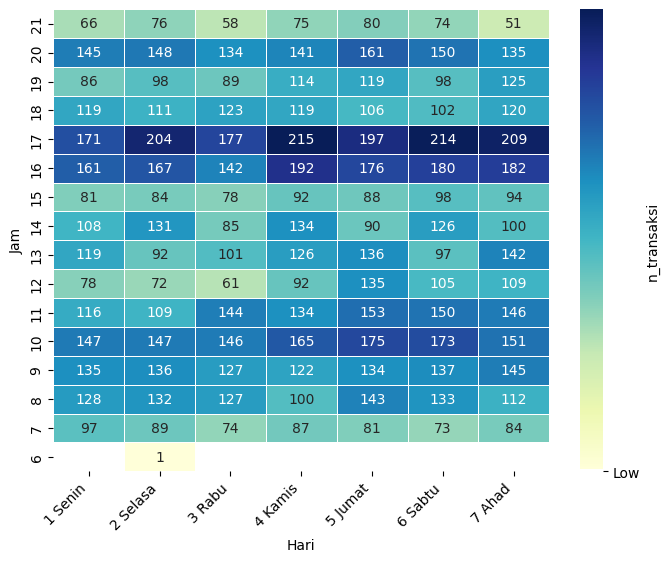

In [9]:
df_waktu = (df_all.groupby(['hari', 'jam'], as_index=False).agg(frekuensi=('id_transaksi', 'nunique')))
df_waktu = df_waktu.pivot(index='jam', columns='hari', values='frekuensi')

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(df_waktu, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'n_transaksi'}, linewidths=0.5)

cbar = heatmap.collections[0].colorbar
cbar.set_ticks([0, df_waktu.values.max()])
cbar.set_ticklabels(['Low', 'High'])
plt.gca().invert_yaxis()
plt.xlabel("Hari")
plt.ylabel("Jam")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Selain tiga grafik di atas, EDA apa lagi yang bisa kita lakukan? Silakan buat sebagai bahan latihan.

## **Tahap III** _Clustering Analysis_ berdasarkan RFM

Pada analisa ini, __kita hanya akan memakai data transaksi dari pelanggan yang menjadi__ ___member___. Sehingga akan ada proses _filtering_ data.

__Definisi:__

- _Retention_ adalah kapan terakhir kali pelanggan bertransaksi pada rentang Januari 2020 sampai April 2020.
- _Frequency_ adalah berapa kali pelanggan bertransaksi pada rentang Januari 2020 sampai April 2020.
- _Monetary_ adalah seberapa besar (secara _value_ rupiah) pelanggan berbelanja pada rentang Januari 2020 sampai April 2020.

Kita akan menghitung ketiga parameter tersebut dengan aturan sebagai berikut:

1. Semua parameter memiliki nilai skala 1-4 (paling rendah ke paling tinggi).
1. _Retention_: pelanggan yang terakhir kali membeli pada:
    - _April_ mendapat skor 4.
    - _March_ mendapat skor 3.
    - _February_ mendapat skor 2.
    - _January_ mendapat skor 1.
1. _Frequency_: kita akan hitung rata-rata transaksi bulanan untuk setiap pelanggan. Kemudian dari semua data yang ada, kita akan bagi menjadi __empat__ kelompok berdasarkan _range_ datanya.
1. Monetary: Kita akan hitung rata-rata belanja bulanan untuk setiap pelanggan. Kemudian dari semua data yang ada, kita akan bagi menjadi __empat__ kelompok berdasarkan _range_ datanya.

In [10]:
df_all.head()

,id_transaksi,tanggal,bulan,hari,jam,ampm,id_pelanggan,sku,qty,unit,harga,diskon,total_harga
0,00001/KSR/UTM/0120,2020-01-02,January,4 Kamis,8,1 pagi,UMUM,KOPIKO COFFE LATTE 240 ML,1,PCS,5400.0,0.0,5400.0
1,00072/KSR/UTM/0120,2020-01-02,January,4 Kamis,13,2 siang,UMUM,GAS 3KG,1,PCS,20000.0,0.0,20000.0
2,00147/KSR/UTM/0120,2020-01-02,January,4 Kamis,18,3 sore,UMUM,QTELA SINGKONG BALADO 185GR,1,PCS,14200.0,0.0,14200.0
3,00147/KSR/UTM/0120,2020-01-02,January,4 Kamis,18,3 sore,UMUM,HYDRO COCO ORIGINAL PET 500ML,1,PCS,11000.0,0.0,11000.0
4,00147/KSR/UTM/0120,2020-01-02,January,4 Kamis,18,3 sore,UMUM,HYDRO COCO ORIGINAL 250 NL,1,PCS,6000.0,0.0,6000.0


In [11]:
# mengambil data yang khusus untuk RFM
# Memfilter data df_all untuk hanya menyertakan pelanggan yang merupakan member (id_pelanggan != "UMUM")
df_rfm = df_all[df_all['id_pelanggan'] !='UMUM']

# perhitungan retention
# Menghitung skor retention berdasarkan bulan terakhir transaksi

df_rfm_1 = df_rfm
# Membuat kolom baru 'retention' dengan skor 1-4 berdasarkan bulan transaksi
df_rfm_1['retention'] = df_rfm_1['bulan'].apply(lambda x: 1 if x == 'January' else  # Jika bulan transaksi Januari, skor retention = 1
                                                          2 if x == 'February' else # Jika bulan transaksi Februari, skor retention = 2
                                                          3 if x == 'March' else # Jika bulan transaksi Maret, skor retention = 3
                                                          4 if x == 'April' else None)# Jika bulan transaksi April, skor retention = 4

# Menghapus baris duplikat berdasarkan kombinasi id_pelanggan dan retention
df_rfm_1 = df_rfm_1[['id_pelanggan', 'retention']].drop_duplicates()
# Mengelompokkan data berdasarkan id_pelanggan dan Memfilter data untuk setiap pelanggan, hanya mempertahankan baris dengan skor retention tertinggi
df_rfm_1 = df_rfm_1.loc[df_rfm_1.groupby('id_pelanggan')['retention'].idxmax()]

# perhitungan frekuensi
# Menghitung frekuensi transaksi per pelanggan
# Mengelompokan berdasarkan id_pelanggan dan menghitum jumlah transaksi unik untuk disimpan pada kolom 'freq'
df_rfm_2 = df_rfm.groupby('id_pelanggan').agg(freq=('id_transaksi', 'nunique')).reset_index()
# Menghitung rata-rata frekuensi transaksi bulanan dengan membagi 'freq' dengan 4 (jumlah bulan)
df_rfm_2['freq'] = df_rfm_2['freq'] / 4
df_rfm_2['freq'] = pd.cut(df_rfm_2['freq'], bins=4, labels=[1, 2, 3, 4]).astype(int)

# perhitungan monetary
# Menghitung total nilai transaksi (monetary) per pelanggan
# Mengelompokkan data berdasarkan id_pelanggan dan menghitung total nilai transaksi per pelanggan dan menyimpannya di kolom 'monetary'
df_rfm_3 = df_rfm.groupby('id_pelanggan').agg(monetary=('total_harga', 'sum')).reset_index()
# Menghitung rata-rata nilai transaksi bulanan dengan membagi 'monetary' dengan 4 (jumlah bulan)
df_rfm_3['monetary'] = df_rfm_3['monetary'] / 4
df_rfm_3['monetary'] = pd.cut(df_rfm_3['monetary'], bins=4, labels=[1, 2, 3, 4]).astype(int)

# Menggabungkan data frame df_rfm_1, df_rfm_2, dan df_rfm_3 menjadi satu data frame df_rfm_all
df_rfm_all = pd.merge(df_rfm_1, df_rfm_2, on='id_pelanggan') # Menggabungkan df_rfm_1 dan df_rfm_2 berdasarkan kolom 'id_pelanggan'
df_rfm_all = pd.merge(df_rfm_all, df_rfm_3, on='id_pelanggan') # Menggabungkan hasil penggabungan sebelumnya dengan df_rfm_3 berdasarkan kolom 'id_pelanggan'

# Membuang kolom id_pelanggan dalam df_rfm_all
df_rfm_all = df_rfm_all.drop(columns=['id_pelanggan'])

# Menskalakan data RFM menggunakan fungsi standardscaler()
scaler = StandardScaler()
df_rfm_all_scaled = scaler.fit_transform(df_rfm_all)
df_rfm_all

,retention,freq,monetary
0,4,1,1
1,2,1,1
2,4,2,2
3,3,1,1
4,4,1,1
...,...,...,...
126,4,1,1
127,1,1,1
128,4,1,1
129,3,1,1


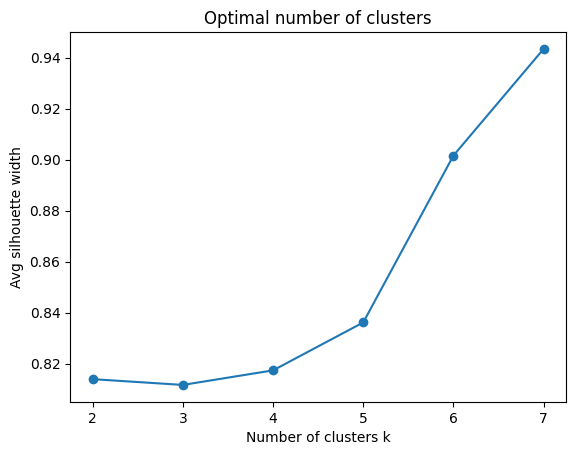

Optimal number of clusters: 7


In [12]:
# Menentukan rentang jumlah cluster (k) yang akan diuji, dari 2 hingga 7
range_k_clusters = range(2,8)
silhouette_avg = []

# Menghitung rata-rata lebar silhouette untuk setiap nilai k
for k in range_k_clusters:
  kmeans = KMeans(n_clusters=k, max_iter=50, random_state = 42) # Parameter yang digunakan untuk kmeans
  cluster_labels = kmeans.fit_predict(df_rfm_all_scaled) # Melakukan clustering k-means
  silhouette_avg.append(silhouette_score(df_rfm_all_scaled, cluster_labels))


# Membuat plot hasil dari clustering
plt.plot(range_k_clusters,silhouette_avg, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('Avg silhouette width')
plt.title('Optimal number of clusters')
plt.show()

# Penentuan jumlah cluster berdasarkan nilai silhouette tertinggi
optimal_k = range_k_clusters[silhouette_avg.index(max(silhouette_avg))]
print(f"Optimal number of clusters: {optimal_k}")




In [13]:
# Melakukan clustering k-means dengan pada data RFM yang telah diskalakan
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans_result = kmeans.fit(df_rfm_all_scaled)
# df_rfm_all_scaled: Data RFM yang telah diskalakan, digunakan sebagai input untuk clustering
# Kluster yang digunakan adalah 7, sesuai dengan hasil perhitungan kluster yang optimal

# Menampilkan hasil clustering K-means
print("\nCluster Sizes (Number of points in each cluster):")
print(np.bincount(kmeans.labels_))
print("Cluster Centers:")
print(pd.DataFrame(kmeans.cluster_centers_, columns=df_rfm_all.columns))
print("\nClustering vector::")
print(kmeans.labels_)



Cluster Sizes (Number of points in each cluster):
[97  4  9  1 10  7  3]
Cluster Centers:
   retention      freq  monetary
0   0.379482 -0.291442 -0.226049
1   0.379482  4.708174  3.138993
2  -3.239412 -0.291442 -0.226049
3   0.379482  1.526600  7.850052
4  -1.334731 -0.291442 -0.226049
5   0.379482  1.786321 -0.226049
6   0.379482  0.314572  2.465985

Clustering vector::
[0 2 6 4 0 0 0 0 2 0 2 0 5 0 0 0 1 0 0 0 0 0 0 0 6 0 4 0 4 0 0 0 0 0 0 5 0
 0 2 0 0 0 0 0 0 0 0 2 0 0 5 0 0 0 0 0 4 0 4 0 0 0 0 0 1 1 2 0 5 0 0 0 0 0
 0 1 0 4 0 0 0 4 0 0 0 0 0 0 0 2 0 0 0 0 0 0 5 0 0 0 0 0 5 0 5 0 0 0 3 2 0
 0 0 0 0 0 4 4 0 0 0 6 0 0 0 0 0 2 0 4 0]


__Discussion Time__

Berikan beberapa strategi untuk _cluster_ pelanggan yang terbentuk! Silakan gunakan data transaksi untuk mendukung strategi Anda!

## **Tahap IV** _Association Rules_ (_Cross Selling_ dan _Upselling_)

Data transaksi belanja merupakan salah satu sumber data yang sangat kaya dengan informasi pada bisnis _retail_. Setidaknya dalam data tersebut, terdapat informasi berupa waktu berbelanja, barang yang dibelanjakan, dan berapa nominal yang dibayarkan oleh pelanggan.

Jika kita bisa mengeksplorasi dan mengeksploitasi data tersebut, kita bisa mendapatkan _insight(s)_ yang menarik dan berguna bagi kelangsungan bisnis _retail_.

> Salah satu pertanyaan yang biasa terjadi pada bisnis _retail_ adalah bagaimana cara kita menentukan produk mana saja yang bisa dijual secara _bundling_?

### Sebelum Mulai Menghitung Produk Bundling

Sebelum masuk ke dalam algoritma apriori, saya akan cari beberapa informasi yang ada dalam data transaksi ini. Tujuannya adalah untuk mengecek  __apakah data transaksi ini bisa digunakan__ untuk membangun analisa produk _bundling_ atau tidak.

Langkah pertama yang saya lakukan adalah menghapus sku `PLAS TIK` dari data transaksi karena sku tersebut bukanlah barang yang 'dijual'.

Kemudian saya coba hitung berapa jenis `sku` yang dibeli oleh pelanggan. Hal yang dihitung adalah berapa jenisnya, bukan `qty`-nya _yah_.

__Misalkan__ ada seorang pelanggan datang membeli:

- `5` bungkus Indomie Ayam Bawang
- `1` bungkus Indomie Kari Ayam
- `1` kg telur

Maka dalam transaksi tersebut ada `3` jenis `sku`.

Sekarang kita akan hitung terlebih dahulu, ada berapa banyak jenis sku yang dibeli oleh __semua pelanggan__ selama `Januari 2020` - `April 2020`.

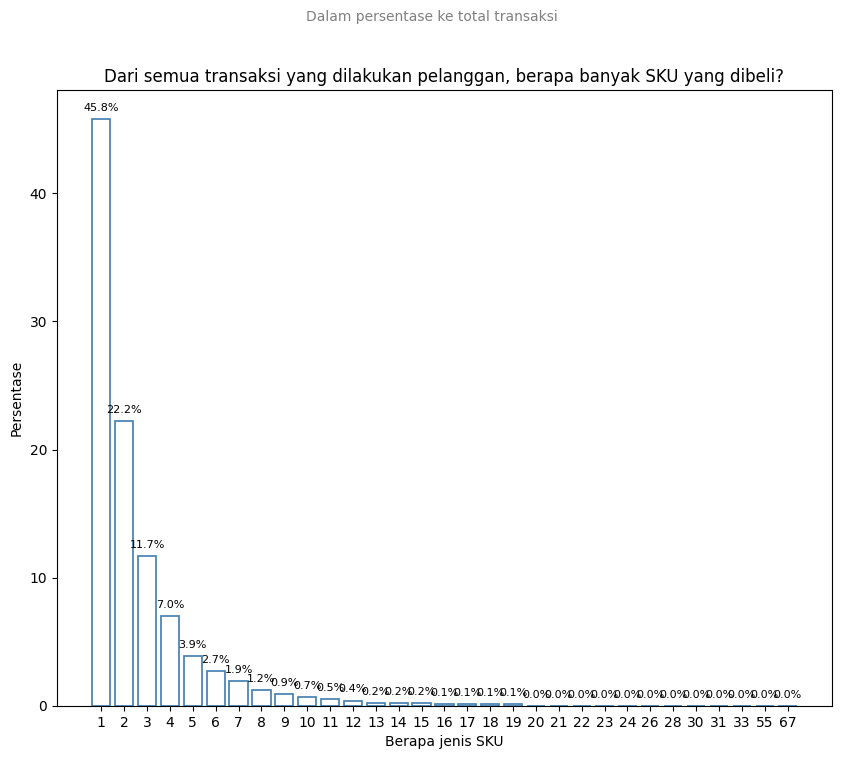

In [14]:
df_baru = df_all[df_all['sku'] != "PLAS TIK"]
df_baru = df_baru.groupby('id_transaksi').agg(barang=('sku', 'size')).reset_index()
df_baru = df_baru.groupby('barang').agg(freq=('id_transaksi', 'nunique')).reset_index()
df_baru['percent'] = df_baru['freq'] / df_baru['freq'].sum() * 100
df_baru['percent'] = df_baru['percent'].round(1)
df_baru['barang'] = df_baru['barang'].astype(str)

plt.figure(figsize= (10,8))
plt.bar(df_baru['barang'], df_baru['percent'], color='white', edgecolor='steelblue', linewidth=1.25)
for i, percent in enumerate(df_baru['percent']):
    plt.text(i, percent + 0.5, f"{percent}%", ha='center', va='bottom', fontsize=8)

plt.xlabel("Berapa jenis SKU")
plt.ylabel("Persentase")
plt.title("Dari semua transaksi yang dilakukan pelanggan, berapa banyak SKU yang dibeli?")
plt.suptitle("Dalam persentase ke total transaksi", fontsize=10, color='gray')
plt.show()

Ternyata setelah kita lihat, `45.8%` dari semua transaksi dilakukan dengan hanya membeli `1` jenis `sku` saja. Sedangkan `22.2%` dari semua transaksi dilakukan dengan membeli `2` jenis `sku` saja.

Mayoritas dari semua transaksi (`r paste0(45.8+22.2,'%')`) hanya membeli 1-2 jenis `sku` saja.

__Mengapa informasi ini diperlukan?__

> Dalam membuat produk bundling, diperlukan data kombinasi sku yang dibeli oleh pelanggan dalam jumlah yang cukup.

Oleh karena jumlah data yang ada relatif terbatas, maka kita akan cek kemudian ada berapa banyak paket _bundling_ yang bisa di-_generate_ dari analisa ini.

Untuk lebih jelasnya, silakan dibaca penjelasan mengenai dasar teori analisa ini.

### Dasar Teori

Ada berbagai macam cara untuk bisa melihat kesamaan dari beberapa produk yang dibeli oleh pelanggan. _Umbrella terms_ dari teknik-teknik tersebut disebut dengan analisa _association_.

_Output_ dari analisa ini disebut dengan _rules_ yaitu:

> predict the occurrence of an item based on the occurrences of other items in the transaction.

Penjelasan yang lebih mudah lagi adalah:

> _if this, then that..._

Perlu diingat bahwa _rules_ dibangun berdasarkan data transaksi yang ada.

### _a little bit of math_

Misalkan:

- Item produk saya tuliskan sebagai: $I = \{i_1,i_2,i_3,...,i_n\}$
- Transaksi saya tuliskan sebagai: $T = \{t_1,t_2,t_3,...,t_n\}$
- Setiap transaksi di $T$ memiliki _unique transaction id_ dan berisi item produk di $I$.

Definisi resmi dari _rules_ adalah:

> _if a user buys an item in the item set on the left hand side, then the user will likely buy the item on the right hand side too_

Secara matematis dinotasikan sebagai: $X \implies Y$, dimana $X,Y	\subseteq I$

- Setiap _rules_ berisi dua himpunan item produk, yakni $X$ dan $Y$.
- Sebagai contoh, _rules_ akan ditulis sebagai berikut: $\{i_1,i_2\} \implies \{i_k\}$.
- Bagian kiri, yakni himpunan produk $(X)$ ditulis __lhs__.
- Bagian kanan, yakni himpunan produk $(Y)$ ditulis __rhs__.

### Contoh Sederhana

Misalkan saya memiliki data transaksi sebagai berikut:

In [15]:
data = {
    'transaction_id': [1, 2, 3, 4, 5],
    'items': ['Milk, Bread', 'Butter', 'Beer, Diapers', 'Milk, Bread, Butter', 'Bread']
}

df = pd.DataFrame(data)
df

,transaction_id,items
0,1,"Milk, Bread"
1,2,Butter
2,3,"Beer, Diapers"
3,4,"Milk, Bread, Butter"
4,5,Bread


Maka, himpunan item produk yang adalah sebagai berikut: $I=\{Milk,Bread,Butter,Beer,Diaper\}$.

Sedangkan himpunan transaksi adalah sebagai berikut: $T=\{1,2,3,4,5\}$.

Salah satu contoh _rules_ dari data di atas adalah:

_If a consumer buys butter and bread, then they are also likely to buy milk_. Dinotasikan: $\{Butter,Bread\} \implies \{Milk\}$

Catatan Penting:

> Implication means co-occurrence, not causality!

### ___Association Rules Parameter___

Dalam analisa asosiasi, ada tiga parameter utama yang akan kita hitung, yakni:

#### ___Support___

Definisi:

> Support is an indication of how frequently the itemset appears in the dataset.

Notasi: $supp(X)=\frac{|\{t \in T,X \subseteq T\}|}{|T|}$

Contoh:

Jika $X=\{Beer,Diapers\}$, maka memiliki nilai _support_ sebesar `20%` (produk _beer_ dan _diapers_ bersamaan ditemukan pada `1` dari `5` transaksi)

#### ___Confidence___

Definisi:

> Confidence is an indication of how often the rule has been found to be true.

_Confidence_ dari suatu _rule_ $X \implies Y$ dari data transaksi dihitung dari proporsi transaksi yang mengandung $X$ dan juga mengandung $Y$.

Notasi: $conf(X \implies Y)=\frac{supp(X \cup Y)}{supp(X)}$

_Confidence_ bisa dilihat sebagai _conditional probability_ $P(E_Y|E_X)$, yakni peluang mendapatkan __rhs__ pada saat transaksi mengandung __lhs__.

Contoh:

Rule $\{Bread,Butter\} \implies \{milk\}$ memiliki nilai _confidence_ = `100%`.

Cara hitungnya:

$$conf(\{Bread,Butter\} \implies \{milk\})=\frac{supp(X \cup Y)}{supp(X)}$$

$$conf(\{Bread,Butter\} \implies \{milk\})=\frac{supp(\{Bread,Butter,Milk\})}{supp(\{Milk\})}$$

$$conf(\{Bread,Butter\} \implies \{milk\})=\frac{1/5}{1/5}=100\%$$

Kesimpulan dari contoh: setiap ada transaksi yang mengandung _itemset_ $\{Bread,Butter\}$ pasti selalu mengandung _itemset_ $\{milk\}$.


#### ___Lift___

Definisi:

> Rasio yang menunjukan apakah _itemset_ $X$ dan _itemset_ $Y$ independen atau tidak.

Jika:

1. $lift<100\%$, artinya __lhs__ dan __rhs__ saling meniadakan (barang substitusi). Peluang _upselling_ dengan menawarkan barang substitusi termahal.
2. $lift=100\%$, artinya __lhs__ dan __rhs__ independen (saling bebas).
3. $lift>100\%$, artinya __lhs__ dan __rhs__ saling bergantung.

Notasi: $lift(X \implies Y)=\frac{supp(X \cup Y)}{supp(X)*supp(Y)}$

Contoh:

Rule $\{Milk, Bread\} \implies \{Butter\}$ memiliki nilai _lift_ = `125%`

Cara hitungnya:

$$lift(\{Milk, Bread\} \implies \{Butter\})=\frac{supp(X \cup Y)}{supp(X)*supp(Y)}$$

$$lift(\{Milk, Bread\} \implies \{Butter\})=\frac{supp(\{Milk, Bread,Butter\})}{supp(\{Milk, Bread\})*supp(\{Butter\})}$$

$$lift(\{Milk, Bread\} \implies \{Butter\})=\frac{1/5}{2/5*2/5}=125\%$$

Kesimpulan dari contoh: _itemset_ __lhs__ dan __rhs__ saling bergantung.

### Menentukan Produk _Bundling_

Setelah membaca penjelasan di atas, maka untuk menentukan produk apa saja yang akan di-_bundling_, kita akan melihat setidaknya dua parameter utama, yakni: _confidence_ dan _lift_ dengan syarat sebagai berikut:

1. _Support_ harus relatif besar, artinya kemunculan _rules_ ini cukup banyak terjadi. Pada hasil _output_, nanti kita bisa melihat parameter bernama _count_.
1. _Confidence_ tinggi, misalkan $>80\%$.
2. _Lift_ harus $>100\%$


### Proses Perhitungan

Untuk menghitung semua kombinasi _rules_ beserta parameternya, saya akan gunakan algoritma apriori.


In [16]:

df_filtered = df_all[df_all['sku'] != 'PLAS TIK'].copy()
df_filtered['sku'] = df_filtered['sku'].apply(lambda x: re.sub(r'[^a-zA-Z0-9 ]', '', x))
df_grouped = df_filtered.groupby('id_transaksi').agg(freq=('sku', 'size'),barang=('sku', lambda x: ','.join(x))).reset_index()
df_grouped[['barang']].to_csv('trans.csv', index=True, header=False)

with open('trans.csv', 'r') as file:
    transactions = [line.strip().split(',')[1:] for line in file]

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df_transactions, min_support=0.0007, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.4)

rules['count'] = rules['support'] * len(df_transactions)
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))
rules = rules.sort_values(by=['count', 'confidence'], ascending=False)


rules.describe()


,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,count
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.001943,0.006943,0.001088,0.594028,232.829086,0.001075,3.251764,0.988165,14.000000
std,0.000544,0.008677,0.000135,0.207321,177.100530,0.000152,2.367125,0.018700,1.732051
min,0.001399,0.001399,0.000933,0.468750,28.331009,0.000900,1.879720,0.966581,12.000000
25%,0.001671,0.001943,0.001049,0.474375,181.704567,0.001031,1.885107,0.982497,13.500000
50%,0.001943,0.002487,0.001166,0.480000,335.078125,0.001162,1.890495,0.998412,15.000000
75%,0.002215,0.009715,0.001166,0.656667,335.078125,0.001162,3.937787,0.998957,15.000000
max,0.002487,0.016943,0.001166,0.833333,335.078125,0.001162,5.985078,0.999501,15.000000


In [17]:
rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,count
1,"""TRANSAKSI PLN 2","TRANSAKSI PLN""",0.001399,0.002487,0.001166,0.833333,335.078125,0.001162,5.985078,0.998412,15.0
2,"TRANSAKSI PLN""","""TRANSAKSI PLN 2",0.002487,0.001399,0.001166,0.468750,335.078125,0.001162,1.879720,0.999501,15.0
0,"""INDOMIE KARI AYAM BAWANG GORENG 70 GR",INDOMIE GORENG 85G,0.001943,0.016943,0.000933,0.480000,28.331009,0.000900,1.890495,0.966581,12.0


### _Detailed Rules_

Mari kita lihat detail semua _rules_ yang ada sebagai berikut:

In [18]:
rules.to_csv("association_rules.csv", index=False)
hasil = pd.read_csv("association_rules.csv")
hasil


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,count
0,"""TRANSAKSI PLN 2","TRANSAKSI PLN""",0.001399,0.002487,0.001166,0.833333,335.078125,0.001162,5.985078,0.998412,15.0
1,"TRANSAKSI PLN""","""TRANSAKSI PLN 2",0.002487,0.001399,0.001166,0.468750,335.078125,0.001162,1.879720,0.999501,15.0
2,"""INDOMIE KARI AYAM BAWANG GORENG 70 GR",INDOMIE GORENG 85G,0.001943,0.016943,0.000933,0.480000,28.331009,0.000900,1.890495,0.966581,12.0


Angka $support$ akan berbanding lurus dengan $count$, oleh karena itu bisa dipilih salah satu saja untuk menentukan _rules_ mana yang __banyak__ terjadi.

Dari _rules_ yang ada, kita bisa lakukan beberapa analisa terkait nilai $lift$.


### Barang Substitusi

Ternyata kita dapatkan bahwa beberapa _rules_ memiliki nilai $lift \leq 100\%$, yakni:


In [19]:
hasil = hasil[hasil['lift']>100]
hasil = hasil[['antecedents', 'consequents', 'count','confidence']]
hasil

,antecedents,consequents,count,confidence
0,"""TRANSAKSI PLN 2","TRANSAKSI PLN""",15.0,0.833333
1,"TRANSAKSI PLN""","""TRANSAKSI PLN 2",15.0,0.468750


Didapatkan ada `??` buah _rules_ yang bisa dijadikan calon _bundling_ produk. Namun, ada beberapa catatan terkait temuan ini:

1. $count$ dari _rules_ yang ada tergolong kecil. Artinya _real cases_ dari _rules_ ini relatif jarang terjadi.
2. $confidence$ yang ada juga masih di $\leq 50\%$.

Berikut visualisasi dari _rules_ tersebut:

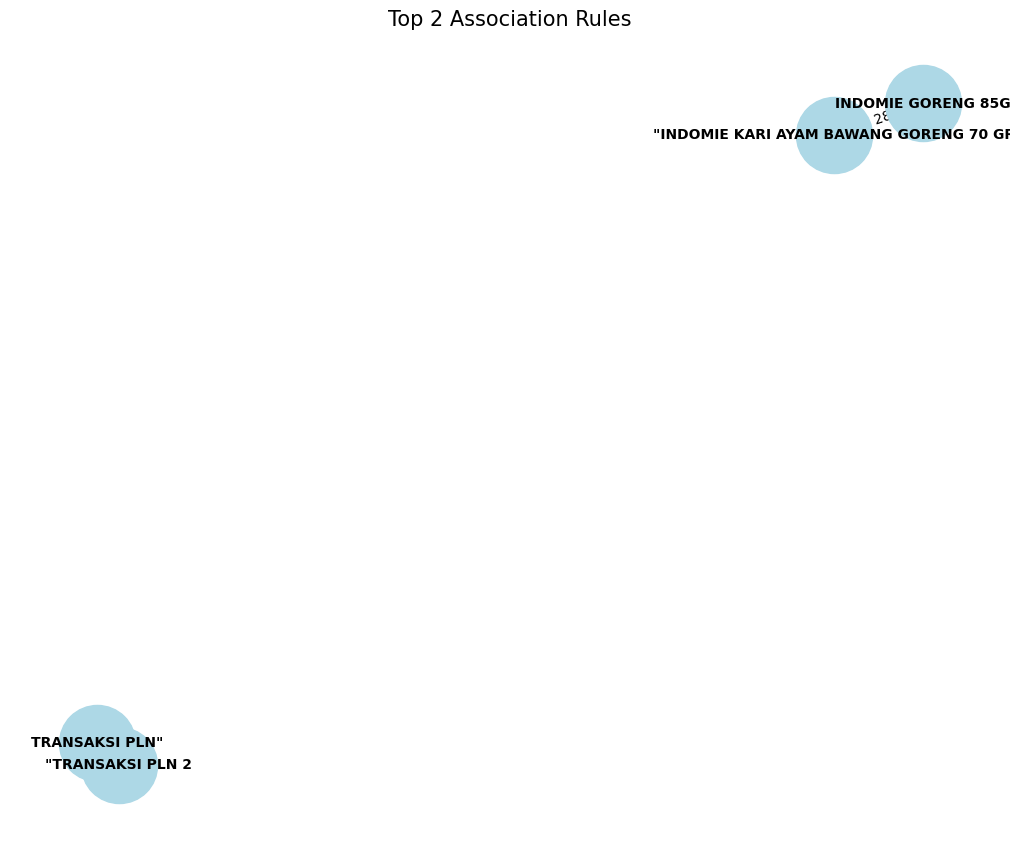

In [20]:

rules_sorted = rules.sort_values(by='lift', ascending=False)

rules_sorted = rules_sorted.head()

G = nx.DiGraph()

for _, row in rules_sorted.iterrows():
    antecedent = str(row['antecedents'])
    consequent = str(row['consequents'])
    lift = row['lift']
    G.add_edge(antecedent, consequent, weight=lift)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight='bold', edge_color="gray")
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'Lift: {d["weight"]:.2f}' for u, v, d in G.edges(data=True)})
plt.title('Top 2 Association Rules', fontsize=15)
plt.show()
